In [ ]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, models, transforms


In [ ]:
ddir = '/content/drive/MyDrive/AI-NN/datasets/hym_data'

batch_size = 4
num_workers = 2

data_transformers = {
    'train': transforms.Compose(
        [
         transforms.RandomResizedCrop(224), 
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
        ]
    ),
    'val': transforms.Compose(
        [
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.490, 0.449, 0.411],[0.231, 0.221, 0.230])
        ]
    )
}

img_data = {
    k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k])
    for k in ['train', 'val']
}
dloaders = {
    k: torch.utils.data.DataLoader(
        img_data[k], batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    for k in ['train', 'val']
}
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes

dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:

import torch
import torch.nn as nn


class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels )
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels !=  out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels , kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels )
            )

  def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))



class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output      


def resnet34(num_classes=100):
    return ResNet(BasicBlock, [3, 4, 6, 3],num_classes=num_classes)  

def resnet18(num_classes=100):
    return ResNet(BasicBlock, [2, 2, 2, 2],num_classes=num_classes)

In [ ]:
model = resnet34(2)
if torch.cuda.is_available() :
  model = model.cuda()
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
def train(model, loss_func, optimizer, epochs=10):
   start = time.time()

   accuracy = 0.0

   for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)

        for dset in ['train', 'val']:
            if dset == 'train':
                model.train()  
            else:
                model.eval() 

            loss = 0.0
            successes = 0

            for imgs, tgts in dloaders[dset]:
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(dset == 'train'):
                    ops = model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)
                    
                    if dset == 'train':
                        loss_curr.backward()
                        optimizer.step()

                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)
          
            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]

            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch      

   time_delta = time.time() - start
   print(f'Training finished in {time_delta // 60}mins {time_delta % 60}secs')
   print(f'Best validation set accuracy: {accuracy}')


   return model


In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
pretrained_model = train(model, loss_func, optimizer, epochs=5)

Epoch number 0/4
train loss in this epoch: 0.8379939925230917, accuracy in this epoch: 0.5532786885245902
val loss in this epoch: 1.5401729986412462, accuracy in this epoch: 0.6928104575163399
Epoch number 1/4
train loss in this epoch: 0.6641162453127689, accuracy in this epoch: 0.6352459016393442
val loss in this epoch: 1.068210408968084, accuracy in this epoch: 0.6143790849673203
Epoch number 2/4
train loss in this epoch: 0.6631305877302514, accuracy in this epoch: 0.6311475409836066
val loss in this epoch: 0.5941575859107223, accuracy in this epoch: 0.6993464052287582
Epoch number 3/4
train loss in this epoch: 0.6306727802167174, accuracy in this epoch: 0.6106557377049181
val loss in this epoch: 0.5368123127549302, accuracy in this epoch: 0.7124183006535948
Epoch number 4/4
train loss in this epoch: 0.6422100917237704, accuracy in this epoch: 0.639344262295082
val loss in this epoch: 0.5884151792144585, accuracy in this epoch: 0.6993464052287582
Training finished in 1.0mins 11.83349

In [ ]:
def test(model=pretrained_model):

  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}


  with torch.no_grad():
      for images, labels in dloaders['val']:


          images = images.to(dvc)
          labels = labels.to(dvc)
        
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)

          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1



  for classname, correct_count in correct_pred.items():
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
test(pretrained_model)

Accuracy for class: ants  is 81.4 %
Accuracy for class: bees  is 60.2 %


In [ ]:
def imageshow(img, text=None):
  img = img.numpy().transpose((1,2,0))
  avg = np.array([0.490, 0.449, 0.411])
  stddev = np.array([0.231, 0.221, 0.230])
  img = stddev * img + avg
  img = np.clip(img, 0, 1)
  plt.imshow(img)
  if text is not None:
    plt.title(text)

In [ ]:
def visualize_predictions(pretrained_model, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(dvc)
            tgts = tgts.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)
            
            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

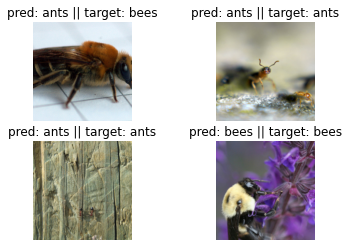

In [ ]:
visualize_predictions(pretrained_model)